In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install --no-index --no-deps /kaggle/input/mmdetectron-31-wheel/pycocotools-2.0.6-cp310-cp310-linux_x86_64.whl
!pip install --no-index --no-deps /kaggle/input/mmdetectron-31-wheel/torch-1.12.1+cu116-cp310-cp310-linux_x86_64.whl
!pip install --no-index --no-deps /kaggle/input/mmdetectron-31-wheel/torchvision-0.13.1+cu116-cp310-cp310-linux_x86_64.whl
!pip install --no-index --no-deps /kaggle/input/mmdetectron-31-wheel/mmcv-2.0.1-cp310-cp310-manylinux1_x86_64.whl 
!pip install --no-index --no-deps /kaggle/input/mmdetectron-31-wheel/openmim-0.3.9-py2.py3-none-any.whl
!pip install --no-index --no-deps /kaggle/input/mmdetectron-31-wheel/mmengine-0.7.4-py3-none-any.whl
!pip install --no-index --no-deps /kaggle/input/mmdetectron-31-wheel/addict-2.4.0-py3-none-any.whl
!pip install --no-index --no-deps /kaggle/input/mmdetectron-31-wheel/mmdet-3.1.0-py3-none-any.whl
!pip install --no-index --no-deps /kaggle/input/mmdetectron-31-wheel/terminaltables-3.1.10-py2.py3-none-any.whl

Processing /kaggle/input/mmdetectron-31-wheel/pycocotools-2.0.6-cp310-cp310-linux_x86_64.whl
Processing /kaggle/input/mmdetectron-31-wheel/torch-1.12.1+cu116-cp310-cp310-linux_x86_64.whl
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0
    Uninstalling torch-2.0.0:
      Successfully uninstalled torch-2.0.0
Processing /kaggle/input/mmdetectron-31-wheel/torchvision-0.13.1+cu116-cp310-cp310-linux_x86_64.whl
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.1
    Uninstalling torchvision-0.15.1:
      Successfully uninstalled torchvision-0.15.1
Processing /kaggle/input/mmdetectron-31-wheel/mmcv-2.0.1-cp310-cp310-manylinux1_x86_64.whl
Processing /kaggle/input/mmdetectron-31-wheel/openmim-0.3.9-py2.py3-none-any.whl
Processing /kaggle/input/mmdetectron-31-wheel/mmengine-0.7.4-py3-none-any.whl
Processing /kaggle/input/mmdetectron-31-wheel/addict-2.4.0-py3-none-any.whl
Processing /kaggle/input/mmdetectron-31-wheel/mmdet-3.1.0-py3-no

In [3]:
from itertools import groupby
from pycocotools import mask as mutils
from pycocotools.coco import COCO
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import os
import cv2,glob
import matplotlib.pyplot as plt
import wandb
from PIL import Image
import gc
sample = None
import mmcv
from glob import glob
import matplotlib.pyplot as plt
from mmdet.apis import init_detector, inference_detector

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

import mmdet as mmdet
print(mmdet.__version__)

from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

1.12.1+cu116 True
3.1.0
11.6
GCC 9.3


In [5]:
import base64
import numpy as np
from pycocotools import _mask as coco_mask
import typing as t
import zlib

def encode_binary_mask(mask: np.ndarray) -> t.Text:
  """Converts a binary mask into OID challenge encoding ascii text."""

  # check input mask --
  if mask.dtype != np.bool:
    raise ValueError(
        "encode_binary_mask expects a binary mask, received dtype == %s" %
        mask.dtype)

  mask = np.squeeze(mask)
  if len(mask.shape) != 2:
    raise ValueError(
        "encode_binary_mask expects a 2d mask, received shape == %s" %
        mask.shape)

  # convert input mask to expected COCO API input --
  mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
  mask_to_encode = mask_to_encode.astype(np.uint8)
  mask_to_encode = np.asfortranarray(mask_to_encode)

  # RLE encode mask --
  encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

  # compress and base64 encoding --
  binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
  base64_str = base64.b64encode(binary_str)
  return base64_str

def remove_overlapping_pixels(mask, other_masks):
    for other_mask in other_masks:
        if np.sum(np.logical_and(mask, other_mask)) > 0:
            mask[np.logical_and(mask, other_mask)] = 0
    return mask

def combine_masks(masks, mask_threshold):
    """
    combine masks into one image
    """
    maskimg = np.zeros((HEIGHT, WIDTH))
    # print(len(masks.shape), masks.shape)
    for m, mask in enumerate(masks,1):
        maskimg[mask>mask_threshold] = m
    return maskimg


def get_filtered_masks(pred):
    """
    filter masks using MIN_SCORE for mask and MAX_THRESHOLD for pixels
    """
    use_masks = []
    use_labels = []
    for i, mask in enumerate(pred["masks"]):
        # Filter-out low-scoring results. Not tried yet.
        scr = pred["scores"][i].cpu().item()
        label = pred["labels"][i].cpu().item()
        if scr > min_score_dict[label]:
            mask = mask.cpu().numpy().squeeze()
            # Keep only highly likely pixels
            binary_mask = mask > mask_threshold_dict[label]
            binary_mask = remove_overlapping_pixels(binary_mask, use_masks)
            use_masks.append(binary_mask)
            use_labels.append(label)

    return use_masks,use_labels

In [6]:
class HuBMAPDataset(torch.utils.data.Dataset):
    def __init__(self, imgs):
        self.imgs = imgs
        self.name_indices = [os.path.splitext(os.path.basename(i))[0] for i in imgs]
    def __getitem__(self, idx):
        # load images and masks
        img_path = self.imgs[idx]
        name = self.name_indices[idx]
        array = tiff.imread(img_path)
        img = Image.fromarray(array)
        return img, name
    def __len__(self):
        return len(self.imgs)
    
test_imgs = glob('/kaggle/input/hubmap-hacking-the-human-vasculature/test/*.tif')
test_dataset = HuBMAPDataset(test_imgs)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

In [7]:
from mmdet.apis import init_detector, inference_detector
from mmengine.config import Config
config_file = '/kaggle/input/hubmap2023-dataset/custom_config_mask-rcnn_r50_fpn_2x_coco_1024_1024.py'
checkpoint_file = '/kaggle/input/hubmap2023-dataset/best_coco_segm_mAP_epoch_19.pth'

cfg = Config.fromfile(config_file )
model = init_detector(cfg, checkpoint_file, device=device)

# cell type specific thresholds
cell_type_dict = {'blood_vessel': 1, 'glomerulus': 2}

mask_threshold_dict = {0: 0.5, 1: 0.80}
min_score_dict = {0: 0.51, 1: 0.80 }

Loads checkpoint by local backend from path: /kaggle/input/hubmap2023-dataset/best_coco_segm_mAP_epoch_19.pth


In [8]:
ids = []
heights = []
widths = []
prediction_strings = []

for img in test_imgs:
    img_array = mmcv.imread(img,channel_order='rgb')
    [h, w, c] = img_array.shape 
    pred = inference_detector(model,img)
    previous_masks = []
    masks_use = []
    labels_use = []
    pred_strings = []
    
    for i, mask in enumerate(pred.pred_instances["masks"]):
        # Filter-out low-scoring results.
        pred_strings_txt=""
        score = pred.pred_instances["scores"][i].cpu().item()
        label = pred.pred_instances["labels"][i].cpu().item()
#         if score > min_score_dict[label]:
        mask = mask.cpu().numpy().astype(np.uint8)
        # Keep only highly likely pixels
#         binary_mask = mask > mask_threshold_dict[label]
#         binary_mask = remove_overlapping_pixels(binary_mask, previous_masks)
#         binary_mask = binary_mask.astype(np.uint8)
        kernel = np.ones(shape=(3, 3), dtype=np.uint8)
        binary_mask = cv2.dilate(mask, kernel, 4)
        binary_mask = binary_mask.astype(bool) 
        masks_use.append(binary_mask)
        labels_use.append(label)
        previous_masks.append(binary_mask)
        encoded = encode_binary_mask(binary_mask)
        #if label != 0: continue
        if i == 0:
            pred_strings_txt += f"{int(label)} {score} {encoded.decode('utf-8')}"
        else:
            pred_strings_txt += f" {int(label)} {score} {encoded.decode('utf-8')}"      
            #print(pred_classes[i])
        pred_strings.append(pred_strings_txt)
    ids.append(str(img).split('.')[0].split('/')[-1])
    heights.append(h)
    widths.append(w)
    prediction_strings.append(" ".join(pred_strings))

/tmp/ipykernel_23/2111801008.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if mask.dtype != np.bool:


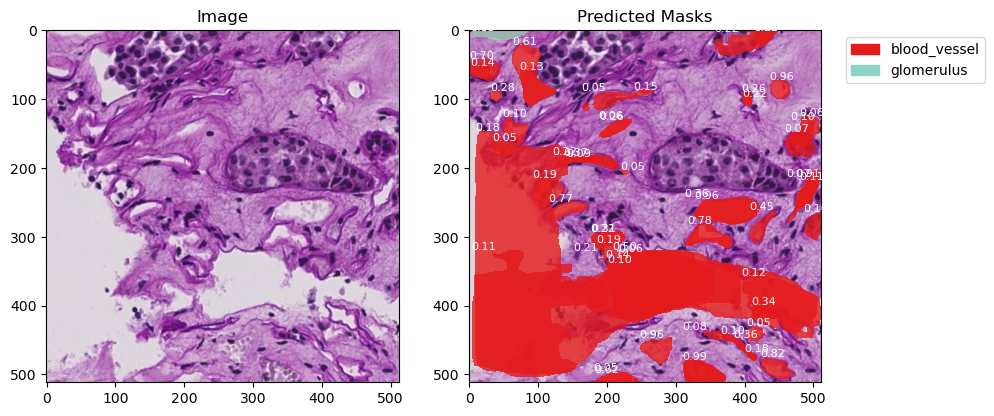

In [9]:
colors = [ 'Set1', 'Set3'] 
legend = {0: 'blood_vessel',1: 'glomerulus'} 
from skimage import io
import matplotlib.patches as mpatches
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
I = io.imread(str(test_imgs[0]))
axs[0].imshow(I)
axs[0].set_title('Image')
axs[1].imshow(I)
pred = inference_detector(model,img)
previous_masks = []
for i, mask in enumerate(pred.pred_instances["masks"]):
    # Filter-out low-scoring results.
    score = pred.pred_instances["scores"][i].cpu().item()
    label = pred.pred_instances["labels"][i].cpu().item()
#     if score > min_score_dict[label]:
    mk = mask.cpu().numpy().astype(np.uint8)
    # Keep only highly likely pixels
#     binary_mask = remove_overlapping_pixels(binary_mask, previous_masks)
#     binary_mask = binary_mask.astype(np.uint8)
    kernel = np.ones(shape=(3, 3), dtype=np.uint8)
    binary_mask = cv2.dilate(mk, kernel, 4)
    previous_masks.append(binary_mask)
    color = colors[label]
    mask = np.ma.masked_where(mk == 0, mk)
    axs[1].imshow(mask, cmap=color, alpha=0.8)
    axs[1].set_title('Predicted Masks')
    # Add score text on each segment
    y, x = np.where(mk > 0)
    text_x, text_y = np.min(x), np.min(y)
    axs[1].text(text_x, text_y, f"{score:.2f}", color='white', fontsize=8)
    handles = []
    for cl in legend:
        color = colors[cl]
        handles.append(mpatches.Patch(color=plt.colormaps.get_cmap(color)(0)))
    axs[1].legend(handles, legend.values(), bbox_to_anchor=(1.05, 1), loc='upper left')

In [10]:
submission = pd.DataFrame()
submission['id'] = ids
submission['height'] = heights
submission['width'] = widths
submission['prediction_string'] = prediction_strings
submission = submission.set_index('id')
submission.to_csv("submission.csv")
submission.head()

,height,width,prediction_string
id,,,
72e40acccadf,512,512,0 0.9926772117614746 eNoLzc8yMTYySLZPM3A08jP1M...
